# Audio Classification using Mel-Spectrogram and 2D CNN

**Project Overview**

This project focuses on the automated classification of Quranic recitations using audio signal processing and Deep Learning. By converting raw audio waveforms into visual representations (spectrograms), the model learns to identify unique phonetic and melodic patterns characteristic of different recitation styles or categories.

**Methodology & Architecture**

The pipeline follows a two-stage approach: Signal Processing and Feature Extraction.Audio Processing PipelineRaw audio is standardized and transformed into the frequency domain to prepare it for a Convolutional Neural Network (CNN):
Resampling: All audio is loaded at a consistent 16,000 Hz sampling rate to ensure a standardized frequency range across all recordings.
Mel Spectrogram Conversion: 1D waveforms are converted into 2D Mel Spectrograms with 128 frequency bins, mapping sound to a scale that mimics human auditory perception.
Logarithmic Scaling: Power values are converted to Decibels (dB) to stabilize the dynamic range.CNN Model Architecture (Net)A custom 2D CNN was designed to process the 1-channel grayscale spectrograms:
Feature Extractor: Three convolutional layers with ReLU activations and MaxPool2d layers to learn spatial hierarchies (from simple edges to complex acoustic textures).
Global Invariance: An Adaptive Average Pooling layer was implemented to ensure the model can handle varying recitation lengths without crashing.
Classifier Head: A dense network with Dropout (0.5) to improve generalization and prevent the model from memorizing recording-specific background noise.

**Training & Optimization**

Optimizer: Adam with a learning rate of 1e-4 for stable, fine-grained convergence.Loss Function: Cross-Entropy Loss, suitable for the multi-class classification of 12 distinct categories.
Data Augmentation & Transforms:
    transforms.ToTensor(), 
    transforms.Resize((128, 128)), # Standardization of input size
    transforms.Normalize(mean=[-40.0], std=[20.0]) # dB scale centering
])

**Performance Results**

The model demonstrated high robustness and a strong ability to generalize to unseen data.

* Training Accuracy - 92.65%
* Validation Accuracy - 91.72%
* Test Accuracy - 91.63%
* Final Test Loss - 0.2555


In [23]:
import os
import torch
import librosa
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

In [24]:
df = pd.read_csv('/kaggle/input/datasets/mohammedalrajeh/quran-recitations-for-audio-classification/files_paths.csv')
df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [25]:
df.size

13374

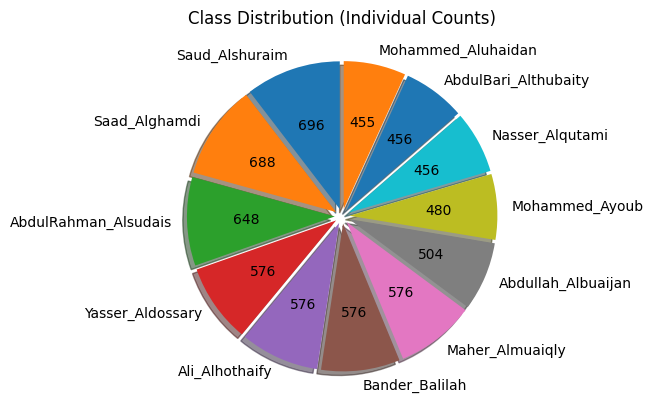

In [27]:
# 1. Get the counts
counts = df['Class'].value_counts()

# 2. Create the pie chart
# The lambda function calculates: (percentage / 100) * total_sum
counts.plot(kind='pie', 
            autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100),
            startangle=90,
            shadow=True,
           explode=[0.05] * len(counts) ) # Adds a slight 'pop' to each slice

plt.title('Class Distribution (Individual Counts)')
plt.ylabel('') # Hides the 'Class' label on the side
plt.show()

In [28]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify= df['Class'])

In [29]:
train_df.shape

(4680, 2)

In [30]:
temp_df.shape

(2007, 2)

In [31]:
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify= temp_df['Class'])

In [32]:
val_df.shape

(1003, 2)

In [33]:
test_df.shape

(1004, 2)

In [34]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# 'Fit' the encoder only on the training data. 
# This identifies all unique classes (e.g., Cat=0, Dog=1).
le.fit(train_df['Class'])

# Transform the text labels into integers for all three datasets.
# We use the mapping learned from the training set to ensure consistency.
train_df['Class'] = le.transform(train_df['Class'])
test_df['Class'] = le.transform(test_df['Class'])
val_df['Class'] = le.transform(val_df['Class'])
test_df.head()

,FilePath,Class
3855,./Dataset/Saud_Alshuraim/Saud_149.wav,10
2528,./Dataset/Bander_Balilah/Bandar_158.wav,4
2937,./Dataset/Bander_Balilah/bander_noiseRed_106.wav,4
4668,./Dataset/Mohammed_Ayoub/mAyoub_262.wav,7
4297,./Dataset/Saud_Alshuraim/Saud_341.wav,10


In [35]:
le.classes_

array(['AbdulBari_Althubaity', 'AbdulRahman_Alsudais',
       'Abdullah_Albuaijan', 'Ali_Alhothaify', 'Bander_Balilah',
       'Maher_Almuaiqly', 'Mohammed_Aluhaidan', 'Mohammed_Ayoub',
       'Nasser_Alqutami', 'Saad_Alghamdi', 'Saud_Alshuraim',
       'Yasser_Aldossary'], dtype=object)

In [36]:
audio_transform = transforms.Compose([
    # 1. Convert Numpy array to Torch Tensor
    transforms.ToTensor(), 
    
    # 2. Resize to a fixed square shape (e.g., 128x128)
    # This ensures every recitation clip looks 'the same' to the CNN
    transforms.Resize((128, 128)),
    
    # 3. Normalization 
    # Since we are using Decibels (dB), values are usually negative. 
    # This helps center the data for the CNN's activation functions.
    transforms.Normalize(mean=[-40.0], std=[20.0]) 
])

In [37]:
class AudioDataSet(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Base path for the Kaggle dataset
        self.base_path = '/kaggle/input/datasets/mohammedalrajeh/quran-recitations-for-audio-classification/Dataset'

    def __len__(self):
        return len(self.dataframe)

    def get_spectrogram(self, full_path):
        # 1. Load audio and resample to 16kHz (Standard for voice)
        y, sr = librosa.load(full_path, sr=16000) 
        
        # 2. Compute Mel Spectrogram (128 frequency bins)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        
        # 3. Convert to log scale (Decibels) for numerical stability
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        return spectrogram_db

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        
        full_path = os.path.join(self.base_path, file_path)
        
        # Generate the 2D spectrogram
        audio_spec = self.get_spectrogram(full_path)
        
        if self.transform:
            # Correctly add the channel dimension: (H, W) -> (H, W, 1)
            # This makes it look like a 1-channel image for the transform pipeline
            audio_spec = np.expand_dims(audio_spec, axis=-1) 
            audio_tensor = self.transform(audio_spec)
        else:
            # If no transform, manually convert to tensor and add channel dim: (1, H, W)
            audio_tensor = torch.tensor(audio_spec).unsqueeze(0)
            
        return audio_tensor, label

In [38]:
train_set = AudioDataSet(train_df, transform=audio_transform)
val_set = AudioDataSet(val_df, transform=audio_transform)
test_set = AudioDataSet(test_df, transform=audio_transform)

In [39]:
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [41]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            # 1 channel input for audio spectrograms
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 -> 64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 -> 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 -> 16
            
            # This makes the final feature map 1x1, very robust!
            nn.AdaptiveAvgPool2d((4, 4)) 
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), 
            # 64 channels * 4 * 4 spatial size = 1024
            nn.Linear(64 * 4 * 4, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Essential for generalization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x input shape: [Batch, 1, 128, 128]
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [42]:
# Check if a NVIDIA GPU is available and configured correctly with CUDA.
# If True, 'device' is set to 'cuda' for hardware acceleration.
# If False, it defaults to 'cpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Device: {device}')

Device: cuda


In [43]:
# Instantiate the model and transfer all its parameters (weights/biases) 
# to the specified hardware (CPU or GPU).
model = Net(num_classes=12).to(device)

In [44]:
#Implementing the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:
# Number of complete passes through the entire training dataset
epochs = 20

# Lists to track performance metrics over time for plotting later
total_train_loss, total_train_acc = [], []
total_val_loss, total_val_acc = [], [] 

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()  # Sets the model to training mode (enables Dropout/BatchNorm)
    running_train_loss = 0.0
    running_train_acc = 0
    
    for images, labels in train_loader:
        # Move a batch of data to the GPU (if available)
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Compute predictions
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Calculate Accuracy: Find the index of the highest logit
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).sum().item()
        
        # Accumulate metrics for the epoch
        running_train_loss += loss.item()
        running_train_acc += acc
        
        # Backward Pass: The optimization steps
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute new gradients (backpropagation)
        optimizer.step()      # Update weights based on gradients
        
    # --- VALIDATION PHASE ---
    model.eval()  # Sets the model to evaluation mode (disables Dropout/BatchNorm)
    
    running_val_loss = 0.0
    running_val_acc = 0
    
    # Disable gradient calculation to save memory and speed up inference
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels).sum().item()
            running_val_loss += loss.item()
            running_val_acc += acc
            
    # --- EPOCH SUMMARY ---
    # Calculate average loss per batch and total accuracy for the dataset
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_set)
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = running_val_acc / len(val_set)
    
    # Store results for visualization
    total_train_loss.append(epoch_train_loss) 
    total_train_acc.append(epoch_train_acc)
    total_val_loss.append(epoch_val_loss)
    total_val_acc.append(epoch_val_acc) 
    
    # Print real-time progress
    print(f'Epoch: {epoch+1} | train loss: {epoch_train_loss:.4f} | train acc: {epoch_train_acc:.4f} | val loss: {epoch_val_loss:.4f} | val acc: {epoch_val_acc:.4f}')

Epoch: 1 | train loss: 2.3392 | train acc: 0.1639 | val loss: 2.0846 | val acc: 0.2433
Epoch: 2 | train loss: 1.9564 | train acc: 0.3045 | val loss: 1.7694 | val acc: 0.3968
Epoch: 3 | train loss: 1.6790 | train acc: 0.4024 | val loss: 1.5314 | val acc: 0.4746
Epoch: 4 | train loss: 1.4424 | train acc: 0.4968 | val loss: 1.2502 | val acc: 0.5663
Epoch: 5 | train loss: 1.2038 | train acc: 0.5893 | val loss: 1.0315 | val acc: 0.6401
Epoch: 6 | train loss: 0.9994 | train acc: 0.6521 | val loss: 0.8735 | val acc: 0.6999
Epoch: 7 | train loss: 0.8336 | train acc: 0.7130 | val loss: 0.7521 | val acc: 0.7438
Epoch: 8 | train loss: 0.7357 | train acc: 0.7472 | val loss: 0.6615 | val acc: 0.7577
Epoch: 9 | train loss: 0.6405 | train acc: 0.7776 | val loss: 0.5849 | val acc: 0.8056
Epoch: 10 | train loss: 0.5537 | train acc: 0.8124 | val loss: 0.5839 | val acc: 0.7856
Epoch: 11 | train loss: 0.4882 | train acc: 0.8284 | val loss: 0.5547 | val acc: 0.8016
Epoch: 12 | train loss: 0.4544 | train ac

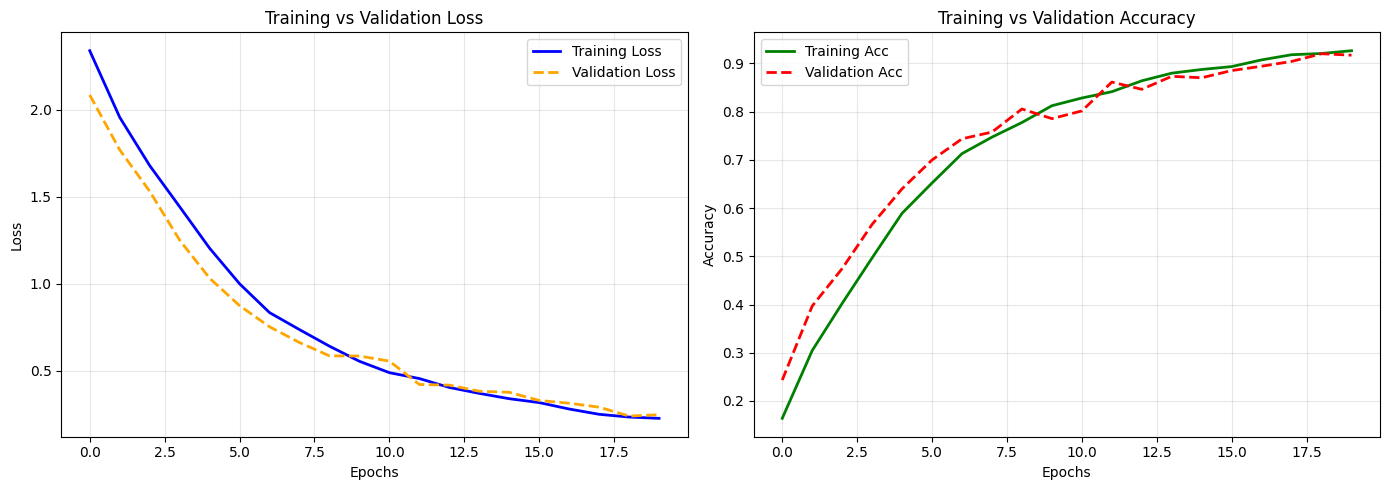

In [46]:
# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(total_train_loss, label='Training Loss', color='blue', lw=2)
plt.plot(total_val_loss, label='Validation Loss', color='orange', lw=2, linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(total_train_acc, label='Training Acc', color='green', lw=2)
plt.plot(total_val_acc, label='Validation Acc', color='red', lw=2, linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
# --- FINAL TEST EVALUATION ---
model.eval()

running_test_loss = 0.0
running_test_acc = 0

# These lists will store every single prediction and true label for cconfusion matrix.
total_preds = []
total_labels = []

# 'no_grad' disables the gradient tracking engine, reducing memory 
# usage and speeding up the computation during inference.
with torch.no_grad():
    for images, labels in test_loader:
        # Move the test batch to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward Pass: Get the model's raw scores (logits)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Determine the predicted class index for each image in the batch
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate how many predictions in this batch were correct
        acc = (preds == labels).sum().item()
        
        # Accumulate the loss and accuracy metrics
        running_test_loss += loss.item()
        running_test_acc += acc
        
        # Move data back to CPU and convert to NumPy for storage in our lists.
        # This is necessary because NumPy cannot live on the GPU.
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

# Calculate the final average loss per batch and overall accuracy percentage
total_test_loss = running_test_loss / len(test_loader)
total_test_acc = running_test_acc / len(test_set)

print(f'Test loss: {total_test_loss:.4f} | Test acc: {total_test_acc:.4f}')

Test loss: 0.2555 | Test acc: 0.9163
